In [146]:
from collections import defaultdict, Counter
import gc

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import mean_squared_error

from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

import eli5
from eli5.sklearn import PermutationImportance

%matplotlib inline

In [147]:
train = pd.read_hdf('../../../input/train_online_retail.h5')
test = pd.read_hdf('../../../input/test_online_retail.h5')
df_all = pd.concat([train, test], sort=False)
del train, test
gc.collect()

df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1067371 entries, 12 to 541893
Data columns (total 11 columns):
invoice         1067371 non-null int32
stock_code      1067371 non-null int16
description     1062989 non-null object
quantity        1067371 non-null int32
invoice_date    1067371 non-null datetime64[ns]
price_unit      1067371 non-null float16
price_total     1067371 non-null float32
customer_id     1067371 non-null int16
country         1067371 non-null object
is_canceled     520142 non-null object
is_test         1067371 non-null bool
dtypes: bool(1), datetime64[ns](1), float16(1), float32(1), int16(2), int32(2), object(3)
memory usage: 60.1+ MB


In [148]:
keys_to_del = []
for key in a.keys():
    if -1 in key: keys_to_del.append(key)
for key in keys_to_del:
    del a[key]

In [173]:
def group_to_dict(df, group_key, agg_func):
    dict_ = df.groupby(group_key)['is_canceled'].agg(agg_func).to_dict()
    
    if len(group_key) >1:
        keys_to_del = []
        for key in dict_.keys():
            if -1 in key: keys_to_del.append(key)
        for key in keys_to_del:
            del dict_[key]
    else:
        if -1 in dict_: del dict_[-1]

        
    mean = np.mean( list(dict_.values()) )
    return defaultdict(lambda: mean, dict_)

In [34]:
train = df_all[ ~df_all['is_canceled'].isnull()]
description_canc = train.groupby(['stock_code', 'description'])['is_canceled'].agg(np.sum).reset_index()
description_canc['is_canceled'] = description_canc['is_canceled'].astype(int)
description_canc['description'] = description_canc['description'].map(lambda x: str(x).strip())
description_canc['words'] = description_canc['description'].map(lambda x: x.split(' '))

most_canceled_words = {}
for i in range(description_canc.shape[0]):
    word_lst = description_canc['words'].iloc[i]    
    for word in word_lst:
        curr_num = most_canceled_words.get(word, 0)
        
        most_canceled_words[word] = curr_num + description_canc['is_canceled'].iloc[i]

#sorted(most_canceled_words.items() ,  key=lambda x: x[1], reverse=True)

words_to_del = []
for word in most_canceled_words.keys():
    if len(word) <= 2:
        words_to_del.append(word)
for word in words_to_del:
    del most_canceled_words[word]
    
most_canceled_words = defaultdict(lambda: 0, most_canceled_words)

stock_code_word_score = {}
for i in range(description_canc.shape[0]):
    word_lst = description_canc['words'].iloc[i]
    stock_score = 0
    for word in word_lst:
        stock_score += most_canceled_words[word]
        
    stock_code_word_score[description_canc['stock_code'].iloc[i]] = stock_score
    
stock_code_word_score = defaultdict(lambda: 0, stock_code_word_score)



In [150]:
def recalculate_params(df):
    dict_cnt_customer_produckt_orders = group_to_dict(df, ['customer_id', 'stock_code'], agg_func=np.size)
    dict_cnt_customer_produckt_cancel = group_to_dict(df, ['customer_id', 'stock_code'], agg_func=np.sum)
    for k, v in dict_cnt_customer_produckt_cancel.items():
        if type(v) != int:
            dict_cnt_customer_produckt_cancel[k] = int(v)

    # customer feats
    df['cnt_customer_orders'] = df['customer_id'].map(group_to_dict(df, ['customer_id'], agg_func=np.size))
    df['cnt_customer_cancel'] = df['customer_id'].map(group_to_dict(df, ['customer_id'], agg_func=np.sum))
    df['prc_customer_cancel'] = df[['cnt_customer_orders', 'cnt_customer_cancel']].apply(lambda x: x['cnt_customer_cancel'] / x['cnt_customer_orders'] if x['cnt_customer_orders'] != 0 else 0, axis=1)

    # produkt feats
    df['cnt_product_orders'] = df['stock_code'].map(group_to_dict(df, ['stock_code'], agg_func=np.size))
    df['cnt_product_cancel'] = df['stock_code'].map(group_to_dict(df, ['stock_code'], agg_func=np.sum))
    df['prc_product_cancel'] = df[['cnt_product_orders', 'cnt_product_cancel']].apply(lambda x: x['cnt_product_cancel'] / x['cnt_product_orders'] if x['cnt_product_orders'] != 0 else 0, axis=1)

    df['cnt_customer_produckt_orders'] = df[['customer_id', 'stock_code']].apply(lambda x: dict_cnt_customer_produckt_orders.get((x['customer_id'], x['stock_code'])), axis=1)
    df['cnt_customer_produckt_cancel'] = df[['customer_id', 'stock_code']].apply(lambda x: dict_cnt_customer_produckt_cancel.get((x['customer_id'], x['stock_code'])), axis=1)
    df['prc_customer_produckt_cancel'] = df[['cnt_customer_produckt_orders', 'cnt_customer_produckt_cancel']].apply(lambda x: x['cnt_customer_produckt_cancel'] / x['cnt_customer_produckt_orders'] if x['cnt_customer_produckt_orders'] != 0 else 0, axis=1)

    # describsion feats
    df['stock_word_score'] = df['stock_code'].map(stock_code_word_score)

    # date feats
    df['invoice_year'] = df['invoice_date'].dt.year
    df['invoice_month'] = df['invoice_date'].dt.month
    df['invoice_day_of_m'] = df['invoice_date'].dt.day
    df['invoice_day_of_y'] = df['invoice_date'].dt.dayofyear
    df['invoice_hour'] = df['invoice_date'].dt.hour

    # category feats
    df['country__cat'] = pd.factorize(df['country'])[0]
    

In [ ]:
recalculate_params(df_all[ ~df_all['is_canceled'].isnull() ])

# Train

In [151]:
def get_feats_X_y(df):
    
    # select feats
    black_list = ['is_canceled', 'is_test', 'total_return', 'is_canceled_pred', 'total_return', 'total_return_pred', 'predict_proba', 'mse']
    feats = df.select_dtypes([np.bool, np.number]).columns
    feats = [x for x in feats if x not in black_list]

    feats = [x for x in feats if x + '_log' not in df.columns]
                  
    X = df[feats].values
    y = df['is_canceled'].values
    
    return X, y, feats

In [152]:
def test_model(model, scoring='f1', check_distribution=False):
    cv = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    print('scores: {}'.format(scores))
    print('mean: {}, std: {} \n'.format(np.mean(scores), np.std(scores)))
    
    if check_distribution:
        y_pred = pd.Series(cross_val_predict(model, X, y, cv=cv))
        print('y_pred value_counts: \n{}'.format(y_pred.value_counts(normalize=True)))

        
        
def plot_model_char(model, check_confusion=True, check_feature_importance=True, check_learning_curve=True):
    
    if check_confusion:
        cv = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)
        y_pred = cross_val_predict(model, X, y, cv=cv)
        skplt.metrics.plot_confusion_matrix(y, y_pred, normalize=True, figsize=(10 ,10))
    
    if check_feature_importance or check_learning_curve:
        model.fit(X, y)
    
    if check_feature_importance:
        skplt.estimators.plot_feature_importances(model, feature_names=feats, x_tick_rotation=90, figsize=(15, 5))
    
    if check_learning_curve:
        skplt.estimators.plot_learning_curve(model, X, y, figsize=(15, 5), cv=3, scoring='recall');

In [153]:
# prepare to train
train = df_all[ ~df_all['is_test'] ].copy()
test = df_all[ df_all['is_test'] ].copy()



#release memory
del df_all
gc.collect()

train['cnt_product_cancel'] = train['cnt_product_cancel'].astype(float)
train['cnt_customer_cancel'] = train['cnt_customer_cancel'].astype(float)

test['cnt_product_cancel'] = test['cnt_product_cancel'].astype(float)
test['cnt_customer_cancel'] = test['cnt_customer_cancel'].astype(float)

train['is_canceled'] = train['is_canceled'].astype(bool)

In [154]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 520142 entries, 12 to 541909
Data columns (total 27 columns):
invoice                         520142 non-null int32
stock_code                      520142 non-null int16
description                     517903 non-null object
quantity                        520142 non-null int32
invoice_date                    520142 non-null datetime64[ns]
price_unit                      520142 non-null float16
price_total                     520142 non-null float32
customer_id                     520142 non-null int16
country                         520142 non-null object
is_canceled                     520142 non-null bool
is_test                         520142 non-null bool
cnt_customer_orders             520142 non-null float64
cnt_customer_cancel             520142 non-null float64
prc_customer_cancel             520142 non-null float64
cnt_product_orders              520142 non-null float64
cnt_product_cancel              520142 non-null float64
p

# Order aproach

In [155]:
train.head()

,invoice,stock_code,description,quantity,invoice_date,price_unit,price_total,customer_id,country,is_canceled,...,cnt_customer_produckt_orders,cnt_customer_produckt_cancel,prc_customer_produckt_cancel,stock_word_score,invoice_year,invoice_month,invoice_day_of_m,invoice_day_of_y,invoice_hour,country__cat
12,2,12,DOOR MAT BLACK FLOCK,10,2009-12-01 09:06:00,5.949219,59.500000,1,United Kingdom,False,...,6.0,0.0,0.0,0,2009,12,1,335,9,0
13,2,13,LOVE BUILDING BLOCK WORD,18,2009-12-01 09:06:00,5.449219,98.099998,1,United Kingdom,False,...,5.0,0.0,0.0,159,2009,12,1,335,9,0
14,2,14,HOME BUILDING BLOCK WORD,3,2009-12-01 09:06:00,5.949219,17.850000,1,United Kingdom,False,...,5.0,0.0,0.0,183,2009,12,1,335,9,0
15,2,15,ASSORTED COLOUR BIRD ORNAMENT,16,2009-12-01 09:06:00,1.690430,27.040001,1,United Kingdom,False,...,4.0,0.0,0.0,0,2009,12,1,335,9,0
16,2,16,PEACE WOODEN BLOCK LETTERS,3,2009-12-01 09:06:00,6.949219,20.850000,1,United Kingdom,False,...,1.0,0.0,0.0,243,2009,12,1,335,9,0


In [156]:
def group_orders(df, params_to_group_by, params_to_agg, agg_fun, label_in_df):
    orders = df.groupby(params_to_group_by)[params_to_agg].agg(agg_fun).reset_index()
    
    if label_in_df:
        orders['is_canceled'] = orders['is_canceled'].map(lambda x: True if x>0 else False)
#         orders['total_return'] = orders['price_total'] * orders['is_canceled']
    return orders

In [157]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 520142 entries, 12 to 541909
Data columns (total 27 columns):
invoice                         520142 non-null int32
stock_code                      520142 non-null int16
description                     517903 non-null object
quantity                        520142 non-null int32
invoice_date                    520142 non-null datetime64[ns]
price_unit                      520142 non-null float16
price_total                     520142 non-null float32
customer_id                     520142 non-null int16
country                         520142 non-null object
is_canceled                     520142 non-null bool
is_test                         520142 non-null bool
cnt_customer_orders             520142 non-null float64
cnt_customer_cancel             520142 non-null float64
prc_customer_cancel             520142 non-null float64
cnt_product_orders              520142 non-null float64
cnt_product_cancel              520142 non-null float64
p

In [158]:
params_to_group_by = ['invoice', 'customer_id', 'invoice_year', 'invoice_day_of_y', 'invoice_hour', 'country__cat']
params_to_sum = ['stock_code', 'price_total', 'is_canceled']
params_to_mean = ['cnt_customer_orders',  'cnt_customer_cancel',  'prc_customer_cancel', 'cnt_product_orders', 'cnt_product_cancel', 'prc_product_cancel', 'stock_word_score', 'cnt_customer_produckt_orders', 'cnt_customer_produckt_cancel', 'prc_customer_produckt_cancel']

In [159]:
train_group_sum = group_orders(train, params_to_group_by, params_to_sum, np.sum, True)
train_group_mean = group_orders(train, params_to_group_by, params_to_mean, np.mean, False)
test_group_sum = group_orders(test, params_to_group_by, params_to_sum, np.sum, False)
test_group_mean = group_orders(test, params_to_group_by, params_to_mean, np.mean, False)

In [160]:
# all agregations into one df
train_group = train_group_mean
test_group = test_group_mean

for param in params_to_sum:
    train_group[param] = train_group_sum[param]
    if param != 'is_canceled':
        test_group[param] = test_group_sum[param]

del train_group_sum, train_group_mean, test_group_sum, test_group_mean


In [161]:
train_group.head()

,invoice,customer_id,invoice_year,invoice_day_of_y,invoice_hour,country__cat,cnt_customer_orders,cnt_customer_cancel,prc_customer_cancel,cnt_product_orders,cnt_product_cancel,prc_product_cancel,stock_word_score,cnt_customer_produckt_orders,cnt_customer_produckt_cancel,prc_customer_produckt_cancel,stock_code,price_total,is_canceled
0,2,1,2009,335,9,0,366.0,30.0,0.081967,460.157895,5.578947,0.018126,410.315789,4.263158,0.526316,0.059911,399.0,630.330017,False
1,3,2,2009,335,9,0,40.0,0.0,0.000000,291.260870,4.391304,0.020913,436.304348,1.086957,0.000000,0.000000,943.0,310.750000,False
2,4,3,2009,335,9,0,498.0,3.0,0.006024,193.764706,1.941176,0.011923,647.705882,1.882353,0.000000,0.000000,1037.0,2286.239990,False
3,5,4,2009,335,9,1,575.0,0.0,0.000000,423.947368,18.157895,0.026849,669.473684,4.947368,0.000000,0.000000,1364.0,426.299988,False
4,8,6,2009,335,9,0,101.0,1.0,0.009901,411.217391,5.739130,0.009393,472.000000,1.391304,0.000000,0.000000,2007.0,382.369995,False


In [162]:
feats_to_log = ['cnt_customer_orders', 'cnt_customer_cancel', 'cnt_product_orders', 'cnt_product_cancel', 'price_total', 'cnt_customer_produckt_orders', 'cnt_customer_produckt_cancel']

for feat in feats_to_log:
    if feat in train_group.columns:
        train_group[feat + '_log'] = np.log1p(train_group[feat])
        if feat != 'total_return':
            test_group[feat + '_log'] = np.log1p(test_group[feat])

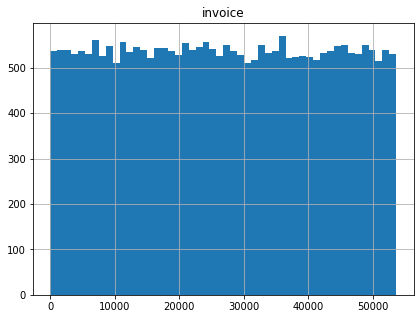

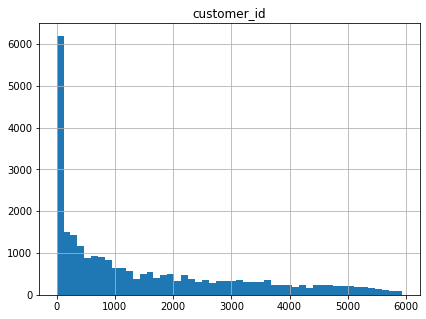

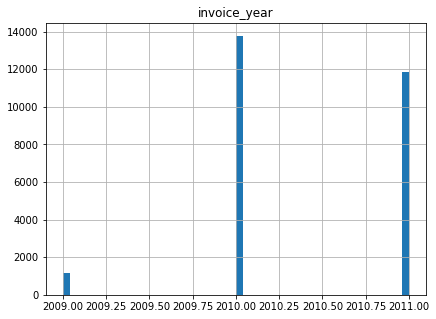

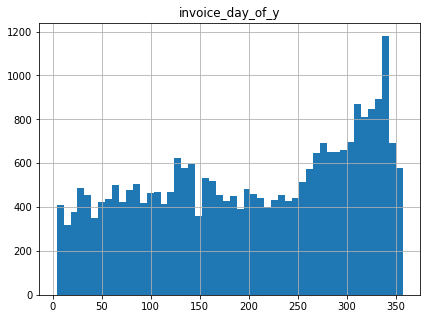

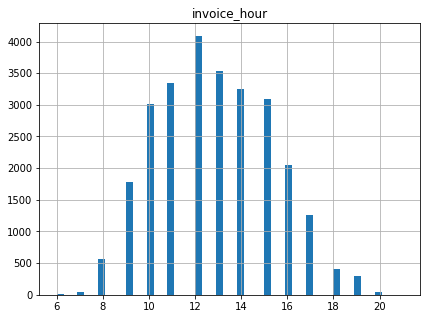

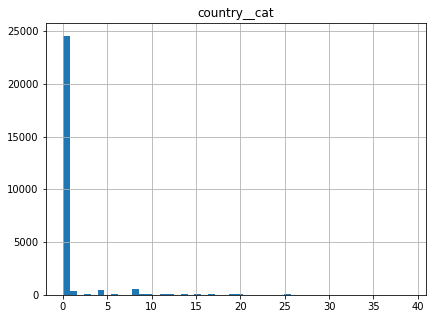

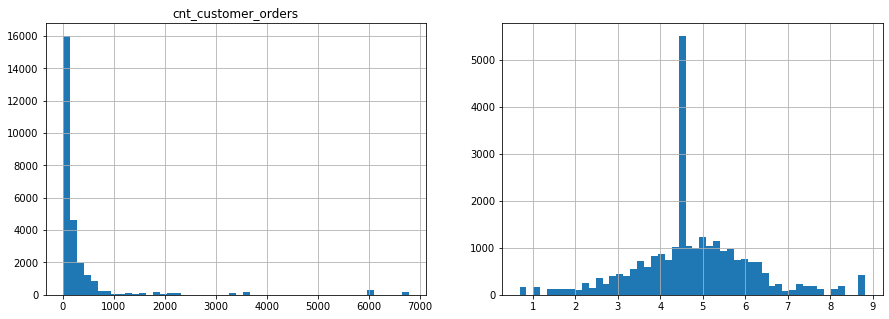

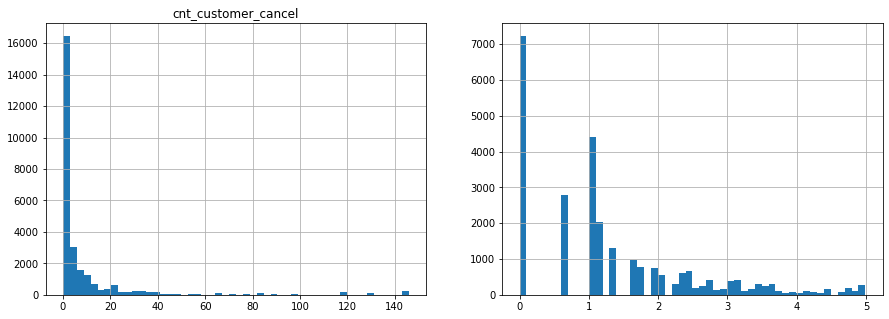

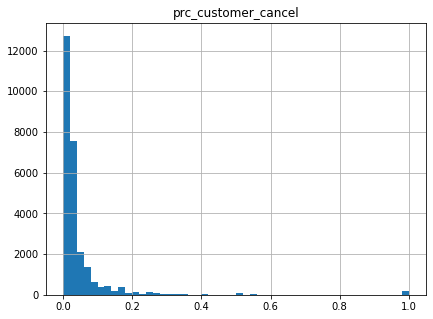

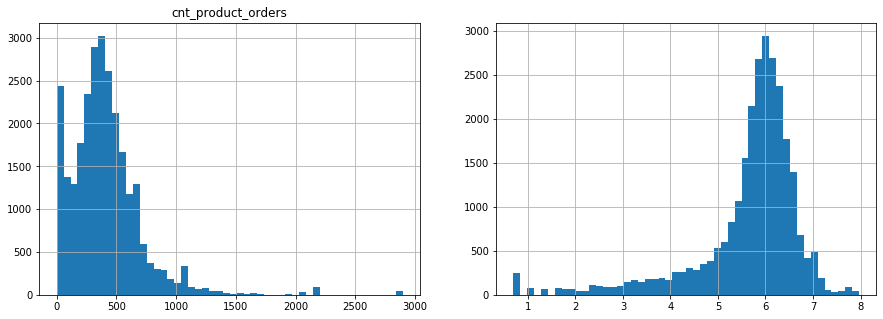

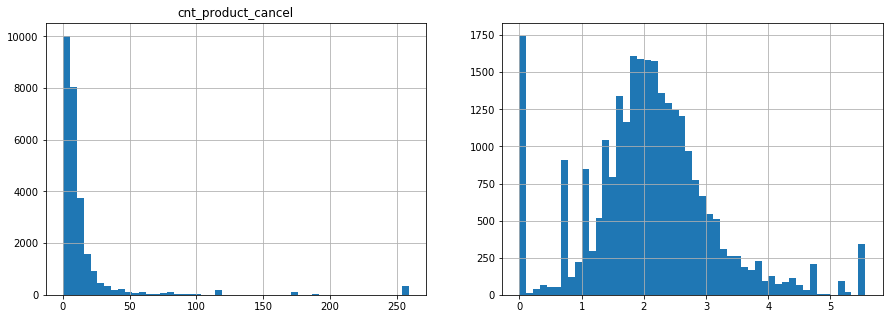

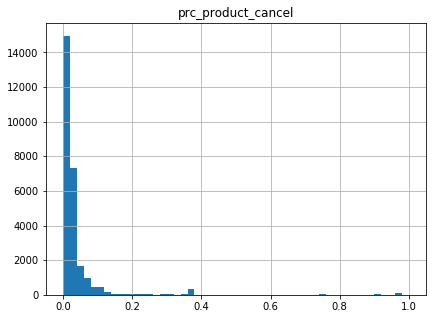

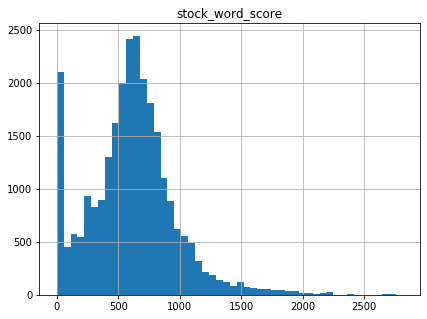

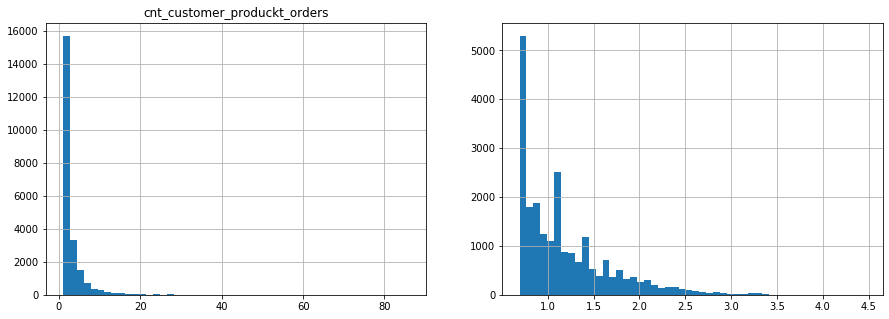

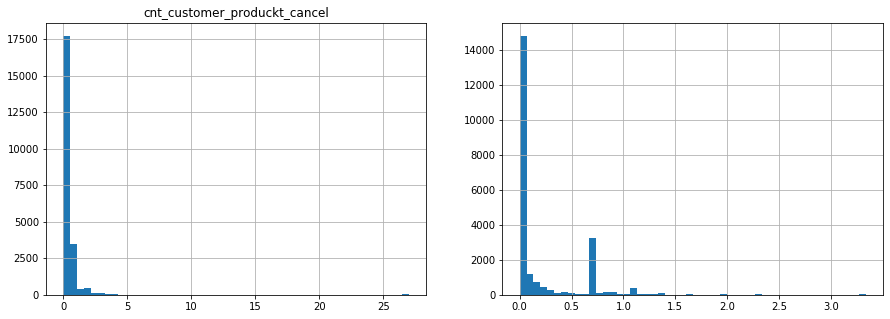

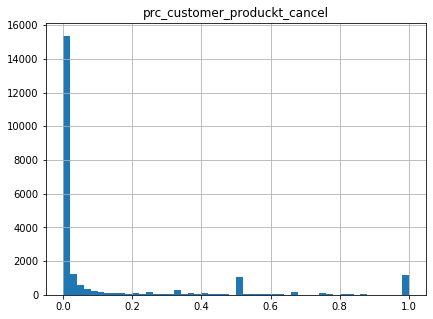

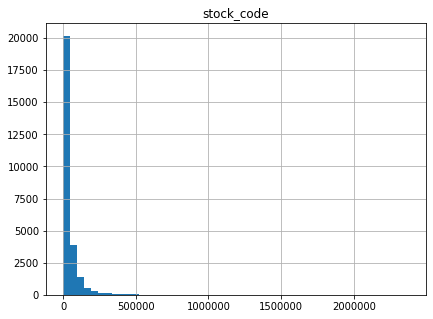

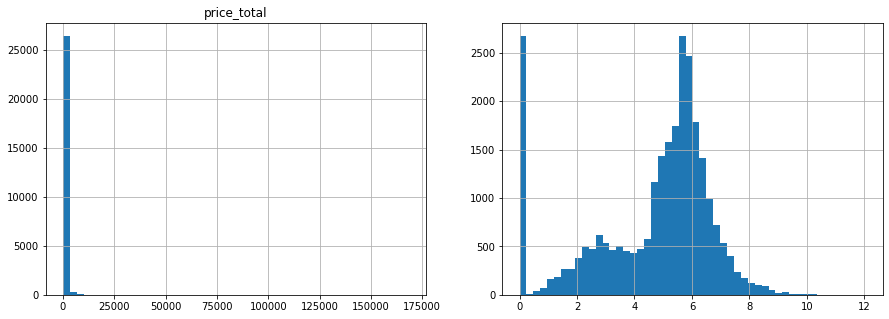

In [163]:
for feat in train_group.columns:
    if 'log' in feat or feat == 'is_canceled': continue
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    train_group[feat].hist(bins=50)
    plt.title(feat)
    if feat in feats_to_log:
        plt.subplot(1,2,2)
        np.log1p(train_group[feat]).hist(bins=50)    
    plt.show()

In [164]:
train_group.head()

,invoice,customer_id,invoice_year,invoice_day_of_y,invoice_hour,country__cat,cnt_customer_orders,cnt_customer_cancel,prc_customer_cancel,cnt_product_orders,...,stock_code,price_total,is_canceled,cnt_customer_orders_log,cnt_customer_cancel_log,cnt_product_orders_log,cnt_product_cancel_log,price_total_log,cnt_customer_produckt_orders_log,cnt_customer_produckt_cancel_log
0,2,1,2009,335,9,0,366.0,30.0,0.081967,460.157895,...,399.0,630.330017,False,5.905362,3.433987,6.133740,1.883875,6.447829,1.660731,0.422857
1,3,2,2009,335,9,0,40.0,0.0,0.000000,291.260870,...,943.0,310.750000,False,3.713572,0.000000,5.677647,1.684787,5.742202,0.735707,0.000000
2,4,3,2009,335,9,0,498.0,3.0,0.006024,193.764706,...,1037.0,2286.239990,False,6.212606,1.386294,5.271792,1.078810,7.735101,1.058607,0.000000
3,5,4,2009,335,9,1,575.0,0.0,0.000000,423.947368,...,1364.0,426.299988,False,6.356108,0.000000,6.051965,2.952715,6.057487,1.782949,0.000000
4,8,6,2009,335,9,0,101.0,1.0,0.009901,411.217391,...,2007.0,382.369995,False,4.624973,0.693147,6.021551,1.907931,5.949000,0.871839,0.000000


In [165]:
X, y, feats = get_feats_X_y(train_group)
feats

['invoice',
 'customer_id',
 'invoice_year',
 'invoice_day_of_y',
 'invoice_hour',
 'country__cat',
 'prc_customer_cancel',
 'prc_product_cancel',
 'stock_word_score',
 'prc_customer_produckt_cancel',
 'stock_code',
 'cnt_customer_orders_log',
 'cnt_customer_cancel_log',
 'cnt_product_orders_log',
 'cnt_product_cancel_log',
 'price_total_log',
 'cnt_customer_produckt_orders_log',
 'cnt_customer_produckt_cancel_log']

In [166]:
# 'learning_rate': 0.05578989271866905, 'max_depth': 14.0

SyntaxError: invalid syntax (<ipython-input-166-5f6c760bee43>, line 1)

In [167]:
xgb_params = {
    'max_depth' : 3,
    'n_estimators' : 50,
    'learning_rate': 0.1,
    'seed': 0
}
model = XGBClassifier(**xgb_params)
X, y, feats = get_feats_X_y(train_group)
test_model(model)

scores: [0.94759207 0.94797273 0.94602273]
mean: 0.9471958419320069, std: 0.0008439488516635215 



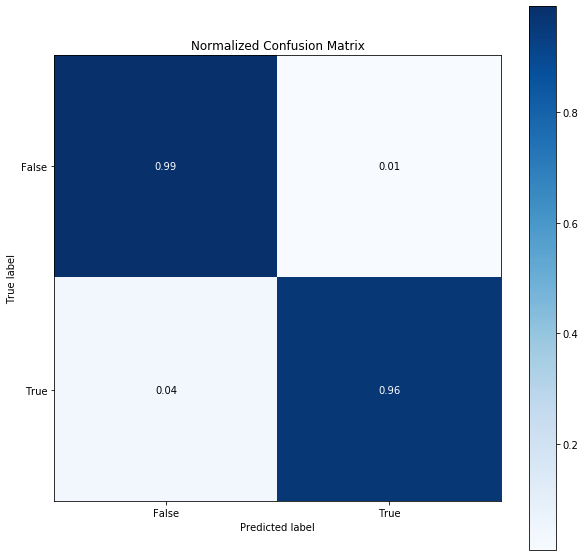

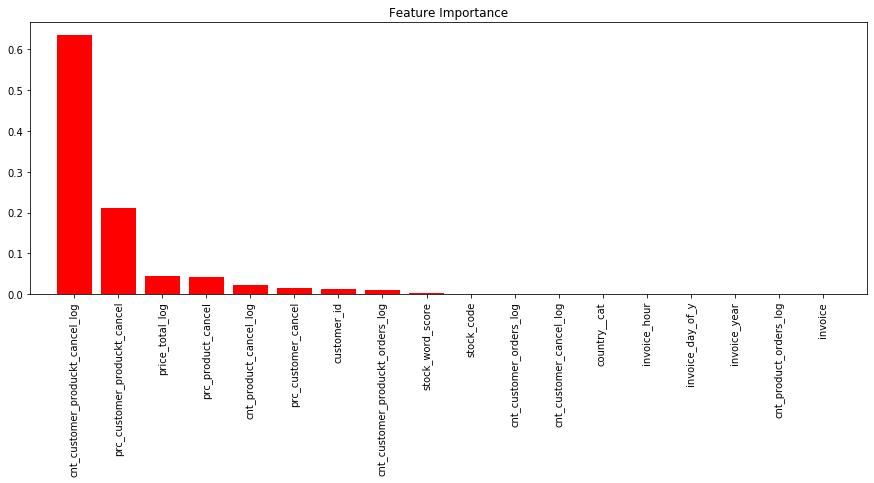

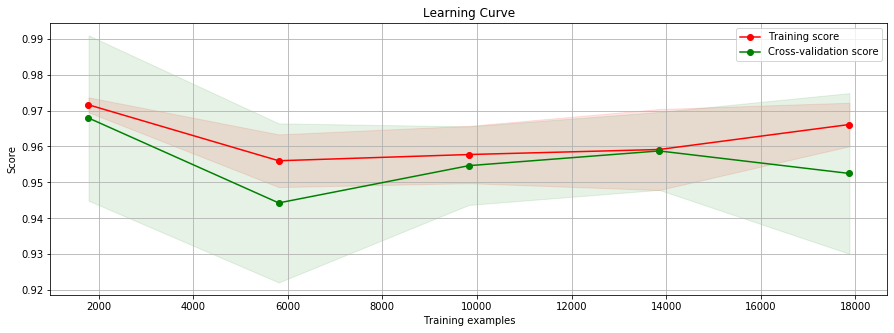

In [168]:
plot_model_char(model)

In [169]:
X, y, feats = get_feats_X_y(train_group)
m = XGBClassifier(**xgb_params)
m.fit(X,y)

imp = PermutationImportance(m, random_state=0).fit(X,y)
eli5.show_weights(imp, feature_names=feats)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [170]:
def fit_and_predict_test(model, df):
    cv = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)
    return cross_val_predict(model, df[feats], df['is_canceled'], cv=cv)

In [176]:
def pred_proba_SKFold(df, xgb_params):
        X, y, feats = get_feats_X_y(df)
        cv = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)
        predict_proba = pd.Series([np.nan] * df.shape[0])
#         df['predict_proba'] = np.nan
        scores = []
        for train_idx, test_idx in cv.split(X, y):
            model = XGBClassifier(**xgb_params)
            model.fit(X[train_idx], y[train_idx])
            predict_proba[test_idx] = [x[1] for x in model.predict_proba(X[test_idx])]
            
        return predict_proba

In [177]:
# calculate mse on train xgb_params_opt_small  is_canceled_pred total_return total_return_pred
treshold = 0.5

model = XGBClassifier(**xgb_params)
if treshold is None:
    train_group['is_canceled_pred'] = fit_and_predict_test(model, train_group)
else:
    train_group['predict_proba'] = pred_proba_SKFold(train_group, xgb_params)
    train_group['is_canceled_pred'] = train_group['predict_proba'].map(lambda x: True if x > treshold else False)
    

train_group['total_return'] = train_group['price_total'] * train_group['is_canceled']

# train_group['total_return_pred'] = train_group['price_total'] * train_group['is_canceled_pred']
train_group['total_return_pred'] = train_group['price_total'] * train_group['predict_proba']


score = mean_squared_error(train_group['total_return'], train_group['total_return_pred'])
print(score)

# score by invoice
train_group['mse'] = train_group[['total_return', 'total_return_pred']].apply(lambda x: mean_squared_error([x['total_return']], [x['total_return_pred']]), axis=1)

# train_group['right_pred'] = train_group[['is_canceled', 'is_canceled_pred']].apply(lambda x: x['is_canceled'] == x['is_canceled_pred'], axis=1)
# train_group.groupby('right_pred')['price_total'].agg(np.sum) / train_group.groupby('right_pred')['price_total'].agg(np.size)

616537.2489172404


In [175]:
train_group.head()

,invoice,customer_id,invoice_year,invoice_day_of_y,invoice_hour,country__cat,cnt_customer_orders,cnt_customer_cancel,prc_customer_cancel,cnt_product_orders,...,stock_code,price_total,is_canceled,cnt_customer_orders_log,cnt_customer_cancel_log,cnt_product_orders_log,cnt_product_cancel_log,price_total_log,cnt_customer_produckt_orders_log,cnt_customer_produckt_cancel_log
0,2,1,2009,335,9,0,366.0,30.0,0.081967,460.157895,...,399.0,630.330017,False,5.905362,3.433987,6.133740,1.883875,6.447829,1.660731,0.422857
1,3,2,2009,335,9,0,40.0,0.0,0.000000,291.260870,...,943.0,310.750000,False,3.713572,0.000000,5.677647,1.684787,5.742202,0.735707,0.000000
2,4,3,2009,335,9,0,498.0,3.0,0.006024,193.764706,...,1037.0,2286.239990,False,6.212606,1.386294,5.271792,1.078810,7.735101,1.058607,0.000000
3,5,4,2009,335,9,1,575.0,0.0,0.000000,423.947368,...,1364.0,426.299988,False,6.356108,0.000000,6.051965,2.952715,6.057487,1.782949,0.000000
4,8,6,2009,335,9,0,101.0,1.0,0.009901,411.217391,...,2007.0,382.369995,False,4.624973,0.693147,6.021551,1.907931,5.949000,0.871839,0.000000


In [240]:
train_group[['predict_proba', 'is_canceled_pred', 'mse']].sample(20)

,predict_proba,is_canceled_pred,mse
5748,0.863967,True,4.080775
5789,0.006090,False,0.000000
26689,0.797019,True,284.931536
18665,0.004089,False,1.175199
17807,0.362329,True,2582.334192
4751,0.907643,True,1.744248
9124,0.009859,False,15.422935
2129,0.019827,True,0.670530
11189,0.013738,True,6.281772
753,0.012100,True,0.371919


In [216]:
pd.set_option('display.max_columns', 50)
train_group.sort_values(by='mse', ascending=False)

,invoice,customer_id,invoice_year,invoice_day_of_y,invoice_hour,cnt_customer_orders,cnt_customer_cancel,prc_customer_cancel,cnt_product_orders,cnt_product_cancel,prc_product_cancel,stock_word_score,stock_code,price_total,is_canceled,cnt_customer_orders_log,cnt_customer_cancel_log,cnt_product_orders_log,cnt_product_cancel_log,price_total_log,predict_proba,is_canceled_pred,total_return,total_return_pred,mse
26792,53587,3689,2011,343,9,2.0000,1.000000,0.500000,2.0,1.0,0.500000,173.0,5304.0,168469.593750,False,1.098612,0.693147,1.098612,0.693147,12.034516,0.803099,True,0.000000,135297.768372,1.830549e+10
15291,30479,836,2011,18,10,32.0000,2.000000,0.062500,132.0,4.0,0.030303,757.0,4647.0,77183.601562,True,3.496508,1.098612,4.890349,1.609438,11.253955,0.049038,False,77183.601562,3784.915971,5.387367e+09
26793,53588,3689,2011,343,9,2.0000,1.000000,0.500000,2.0,1.0,0.500000,173.0,5304.0,168469.593750,True,1.098612,0.693147,1.098612,0.693147,12.034516,0.649625,False,168469.593750,109442.130693,3.484241e+09
14302,28454,-1,2010,341,15,83.6942,1.980324,0.023661,24.0,22.0,0.916667,44.0,9148.0,27082.660156,False,4.439047,1.092032,3.218876,3.135494,10.206686,0.762160,True,0.000000,20641.307437,4.260636e+08
19656,39260,5040,2011,161,15,2.0000,1.000000,0.500000,693.0,259.0,0.373737,259.0,1232.0,38970.000000,True,1.098612,0.693147,6.542472,5.560682,10.570573,0.545133,False,38970.000000,21243.849061,3.142164e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8378,16747,-1,2010,210,15,83.6942,1.980324,0.023661,35.0,6.0,0.171429,1513.0,4248.0,0.000000,False,4.439047,1.092032,3.583519,1.945910,0.000000,0.033285,False,0.000000,0.000000,0.000000e+00
8339,16677,-1,2010,210,10,83.6942,1.980324,0.023661,267.0,9.0,0.033708,0.0,621.0,0.000000,False,4.439047,1.092032,5.590987,2.302585,0.000000,0.031157,False,0.000000,0.000000,0.000000e+00
8285,16578,-1,2010,208,16,83.6942,1.980324,0.023661,37.0,4.0,0.108108,112.0,263.0,0.000000,False,4.439047,1.092032,3.637586,1.609438,0.000000,0.026617,False,0.000000,0.000000,0.000000e+00
23403,46769,-1,2011,278,11,83.6942,1.980324,0.023661,538.0,5.0,0.009294,0.0,4802.0,0.000000,False,4.439047,1.092032,6.289716,1.791759,0.000000,0.014977,False,0.000000,0.000000,0.000000e+00


# Hyper opt

In [180]:
def hyperOptf1(train):
    X, y, feats = get_feats_X_y(train)


    def objective(space):

        xgb_params = {
            'max_depth': int(space['max_depth']),
            'learning_rate': space['learning_rate'],
            'colsample_bytree': space['colsample_bytree'],
            'subsample': space['subsample'],
            'min_child_weight': int(space['min_child_weight']),
            'n_estimators': 50,
            'objective': 'reg:squarederror',
            'seed':0
        }
        
    
        predict_proba = pred_proba_SKFold(train_group, xgb_params)
        return_pred = train['price_total'] * predict_proba
        final_score = mean_squared_error(return_pred, train['total_return'])
        
        print('final_score: {}'.format(final_score))
        return{'loss':final_score, 'status': STATUS_OK }

    space ={
        'max_depth': hp.quniform ('max_depth', 1, 20, 1),
        'colsample_bytree': hp.uniform ('colsample_bytree', 0.8, 1.),
        'subsample': hp.uniform ('subsample', 0.7, 1.),
        'learning_rate': hp.uniform ('learning_rate', 0.05, 0.3),
        'min_child_weight': hp.quniform ('min_child_weight', 1, 10, 1),
    }


    trials = Trials()
    best_params = fmin(fn=objective,
                space=space,
                algo=partial(tpe.suggest, n_startup_jobs=10),
                max_evals=50,
                trials=trials)

    print("The best params: ", best_params)

In [181]:
hyperOptf1(train_group)

final_score: 639425.4112033254                        
final_score: 1848889.2601738216                                                
final_score: 1271258.9430132913                                                
final_score: 683395.7389440052                                                 
final_score: 678912.007682289                                                  
final_score: 2213366.46449412                                                  
final_score: 1680001.119601212                                                 
final_score: 1849496.2589090357                                                
final_score: 1059334.25856964                                                  
final_score: 1282957.9782914892                                                
final_score: 2105946.731097127                                                  
final_score: 1925966.2058389406                                                 
final_score: 2128069.761675359                                 

In [124]:
feats

['invoice',
 'customer_id',
 'invoice_year',
 'invoice_day_of_y',
 'invoice_hour',
 'country__cat',
 'prc_customer_cancel',
 'prc_product_cancel',
 'stock_word_score',
 'prc_customer_produckt_cancel',
 'stock_code',
 'cnt_customer_orders_log',
 'cnt_customer_cancel_log',
 'cnt_product_orders_log',
 'cnt_product_cancel_log',
 'price_total_log',
 'cnt_customer_produckt_orders_log',
 'cnt_customer_produckt_cancel_log']

In [191]:
xgb_params_opt = {'n_estimators': 50, 'seed':0, 'learning_rate': 0.05068313243959119, 'max_depth': 6, 'min_child_weight': 1}

In [125]:
# final predict two models

X, y, feats = get_feats_X_y(train_group)

model = XGBClassifier(**xgb_params)
model.fit(train_group[feats], train_group['is_canceled'])
test_group['is_canceled'] = [x[1] for x in model.predict_proba(test_group[feats])]

importances = model.feature_importances_
for f, i in list(zip(feats, importances)):
    print(f,i)

invoice 0.0
customer_id 0.012235843
invoice_year 0.0
invoice_day_of_y 0.0
invoice_hour 0.0
country__cat 0.0
prc_customer_cancel 0.016232803
prc_product_cancel 0.042625464
stock_word_score 0.003859202
prc_customer_produckt_cancel 0.21205594
stock_code 0.0
cnt_customer_orders_log 0.0
cnt_customer_cancel_log 0.0
cnt_product_orders_log 0.0
cnt_product_cancel_log 0.023551222
price_total_log 0.045583062
cnt_customer_produckt_orders_log 0.00943241
cnt_customer_produckt_cancel_log 0.63442403


In [126]:
#prepare submit
test_group['total_return'] = test_group['price_total'] * test_group['is_canceled']
test_group[ ['invoice', 'total_return'] ].to_csv('../../../output/xgb_and_cnt_features.csv', index=False)